In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
warnings.simplefilter(action='ignore', category=FutureWarning)
%run data_intake.ipynb
import os

In [4]:
aquastat_file_names = [fn for fn in os.listdir("data/") if ".xlsx" in fn]

aquastat_crop_yield = pipeline(aquastat_file_names, "Attainable_yields.csv", "value")

aquastat_crop_yield

Country  Year  agricultural_value_added_percent_of_gdp  \
53     Albania  2018                                18.429476   
54     Albania  2017                                19.022127   
55     Albania  2016                                19.849993   
56     Albania  2015                                19.780225   
57     Albania  2014                                19.990153   
...        ...   ...                                      ...   
9565  Zimbabwe  1974                                13.822747   
9566  Zimbabwe  1973                                11.305693   
9567  Zimbabwe  1972                                13.466776   
9568  Zimbabwe  1971                                13.129246   
9569  Zimbabwe  1970                                11.579776   

      arable_land_area  gdp_per_capita  precipitation_index  \
53             611.346     5257.650696              1136.00   
54             612.000     4514.204908              1136.00   
55             620.300     4109.340457              1136.00   
56             615.100     3939.413126              1136.00   
57             615.600     4567.281443              1136.00   
...                ...             ...                  ...   
9565          2465.000      811.510083               746.72   
9566          2415.000      698.192005               712.18   
9567          2415.000      588.037380               677.64   
9568          2385.000      493.287110               643.10   
9569          2335.000      441.744085               645.68   

      total_exploitable_water_resources  \
53                                 13.0   
54                                 13.0   
55                                 13.0   
56                                 13.0   
57                                 13.0   
...                                 ...   
9565                                1.5   
9566                                1.5   
9567                                1.5   
9568                                1.5   
9569                                1.5   

      total_internal_renewable_water_resource_per_capita  total_population  \
53                                          9331.399988           2882.740   
54                                          9326.776621           2884.169   
55                                          9319.444935           2886.438   
56                                          9306.306528           2890.513   
57                                          9287.695875           2896.305   
...                                                 ...                ...   
9565                                        2014.765967           6085.074   
9566                                        2085.840681           5877.726   
9567                                        2160.767062           5673.911   
9568                                        2238.459064           5476.982   
9569                                        2317.885740           5289.303   

      total_renewable_water_resources  total_yield  
53                               30.2        87.14  
54                               30.2        69.81  
55                               30.2        68.46  
56                               30.2        71.04  
57                               30.2        68.50  
...                               ...          ...  
9565                             20.0       141.67  
9566                             20.0       112.67  
9567                             20.0       125.86  
9568                             20.0       132.97  
9569                             20.0       123.17  

[1920 rows x 11 columns]

In [5]:
# descends the model by a single step
def descend(true_y, pred_y, x, b, alpha=0.01):
    return b - alpha*np.sum(np.subtract(pred_y, true_y)*x)/true_y.size

In [6]:
# Returns a list of predictions for total yield when given X values and b values
def predict(X, b):
    return np.add(np.matmul(X.loc[:, X.columns != 'b0'],b[1:]), b[0])

In [7]:
def mse(true, pred):
    return np.square(np.subtract(true,pred)).mean()

In [6]:
def lin_regression(data, alpha=0.00001, epochs=1000, stats=True, y_col='total_yield', print_=False):
    # generates initial w values
    b = np.zeros(len(data.axes[1]))
    #b = random.rand(len(data.axes[1]))
    
    # removes outcome from data, and inserts a dummy column for w0
    fdata = data.loc[:, data.columns != y_col]
    fdata.insert(0, 'b0', np.ones(len(data)))
    
    if stats:
        mse_list = []
    
    for i in range(epochs):

        pred = predict(fdata, b)
        
        if print_:
            print(b, pred)
        
        # Ends early if the value increases too much
        if math.isnan(pred[0]) or math.isinf(pred[0]):
            print("Value increased to infinity")
            if stats:
                return b, mse_list
            else:
                return b
        
        if stats:
            # Calculates mpe and acc for each epoch
            mse_list.append(mse(data[y_col], pred))
        
        index = 0
        for col in fdata:
            b[index] = descend(data[y_col], pred, fdata[col], b[index], alpha=alpha)
            index +=1
    
    if stats:
        return b, mse_list
    else:
        return b

In [7]:
def pipeline_separate(aquastat_filenames, crop_yield_filename, aquastat_feature):
    """
    Runs the aquastat and crop yield pipeline
    """
    shared_attributes = ["Country", "Year"]
    crop_df = crop_yield_specialized_preprocessing(convert_to_pandas(crop_yield_filename))
    dfs = []
    for fn in aquastat_filenames:
        temp_df = convert_to_pandas(fn)
        strip_temp_df = strip_df(temp_df, shared_attributes + [aquastat_feature])
        renamed_temp_df = aquastat_feature_rename(strip_temp_df, fn, aquastat_feature)
        dfs.append(strip_temp_df)
    
    dfs.append(crop_df)
    
    return dfs

In [8]:
dfs = pipeline_separate(aquastat_file_names, "Attainable_yields.csv", "value")
dfs

[           Country  Year  total_renewable_water_resources
 0      Afghanistan  2020                            65.33
 1      Afghanistan  2019                            65.33
 2      Afghanistan  2018                            65.33
 3      Afghanistan  2017                            65.33
 4      Afghanistan  2016                            65.33
 ...            ...   ...                              ...
 10438     Zimbabwe  1968                            20.00
 10439     Zimbabwe  1967                            20.00
 10440     Zimbabwe  1966                            20.00
 10441     Zimbabwe  1965                            20.00
 10442     Zimbabwe  1964                            20.00
 
 [10443 rows x 3 columns],
           Country  Year  agricultural_value_added_percent_of_gdp
 0     Afghanistan  2020                                27.013561
 1     Afghanistan  2019                                25.773971
 2     Afghanistan  2018                                22.042897

In [9]:
def test_combos(dfs, yield_df, combination_size=2, alpha_vals=[0.001, 0.0001]):
    results = []
    for size in range(combination_size):
        combs = itertools.combinations(dfs, size)
    
        # Iterates through the list of combination
        for comb in combs:
            data = yield_df
        
            # Merges all the dataframes in the combination into 1
            for df in comb:
                data = data.merge(df, on=["Country", "Year"])
            
            data = data.drop(["Country", "Year"], axis=1)
        
            # Runs linear regression using the given alpha levels
            for alpha in alpha_vals:
                beta, mse_list = lin_regression(data, epochs=1000, alpha=alpha)
                mse_val = mse_list[-1]
            
                # Ensures mse_val is a number
                if math.isnan(mse_val) or math.isinf(mse_val):
                    mse_val = 99999999
                
                results.append((mse_val, beta, alpha, data.axes[1]))
            
            
    return results

In [10]:
combos = test_combos(dfs[:-1], dfs[-1], combination_size=3, alpha_vals=[0.001, 0.0001, 0.00001, 0.000001])

C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
valid_combos = [combo for combo in combos if combo[0] < 99999999]
valid_combos

[(3054.4387665004588,
  array([45.3848944]),
  0.001,
  Index(['total_yield'], dtype='object')),
 (6575.348571806306,
  array([6.83080472]),
  0.0001,
  Index(['total_yield'], dtype='object')),
 (7406.519053203892,
  array([0.71419615]),
  1e-05,
  Index(['total_yield'], dtype='object')),
 (7498.150334485239,
  array([0.07174111]),
  1e-06,
  Index(['total_yield'], dtype='object')),
 (3278.119111582906,
  array([27.57768629,  1.52490335]),
  0.001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4591.935393496021,
  array([3.43819034, 2.39669109]),
  0.0001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4793.404671043973,
  array([0.43118005, 2.46670393]),
  1e-05,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (5963.968002533865,
  array([0.06524753, 0.85748051]),
  1e-06,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (2848.

In [12]:
final_df = dfs[-1].merge(dfs[0], on=["Country", "Year"]).merge(dfs[3], on=["Country", "Year"])

,Country,Year,total_yield,gdp_per_capita,total_renewable_water_resources
0,Afghanistan,1970,33.03,154.957138,65.33
1,Afghanistan,1971,33.16,157.975357,65.33
2,Afghanistan,1972,33.15,139.756605,65.33
3,Afghanistan,1973,33.57,140.616194,65.33
4,Afghanistan,1974,35.40,166.095029,65.33
...,...,...,...,...,...
6033,Zimbabwe,2014,122.40,1434.896596,20.00
6034,Zimbabwe,2015,109.41,1445.071063,20.00
6035,Zimbabwe,2016,111.70,1464.589686,20.00
6036,Zimbabwe,2017,113.47,1548.186368,20.00


In [13]:
# Runs the linear regression with only agricultural_value_added_percent_of_gdp and flood_occurence 
beta, mse_list = lin_regression(final_df.drop(["Country", "Year"], axis=1), epochs=1000, alpha=0.000001)

Value increased to infinity


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
pred = predict(final_df.drop(["Country", "Year", "total_yield"], axis=1), beta)
true = final_df["total_yield"]

In [26]:
results = pd.DataFrame({'true': true, 'pred':pred})
results = results.sort_values(by=['true'])

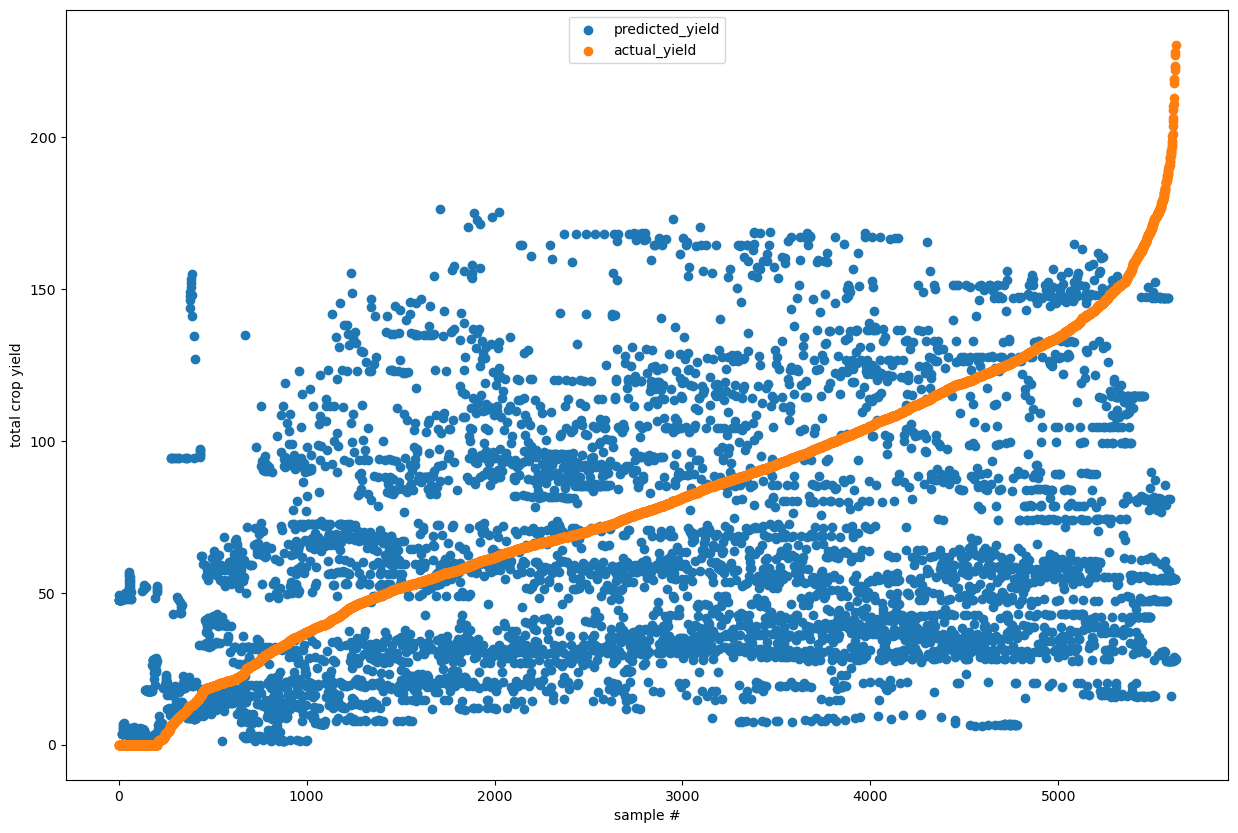

In [27]:
# Plots something for sure
X = range(len(pred))
y = final_df["total_yield"]
plt.figure(figsize = (15,10))
plt.scatter(X, results['pred'], label="predicted_yield")
plt.scatter(X, results['true'], label="actual_yield")
leg = plt.legend(loc='upper center')
plt.xlabel('sample #')
plt.ylabel('total crop yield')
plt.show()

In [28]:
polyreg=make_pipeline(PolynomialFeatures(5),LinearRegression())
polyreg.fit(final_df.drop(["Country", "Year", "total_yield"], axis=1),final_df["total_yield"])

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=5)),
                ('linearregression', LinearRegression())])

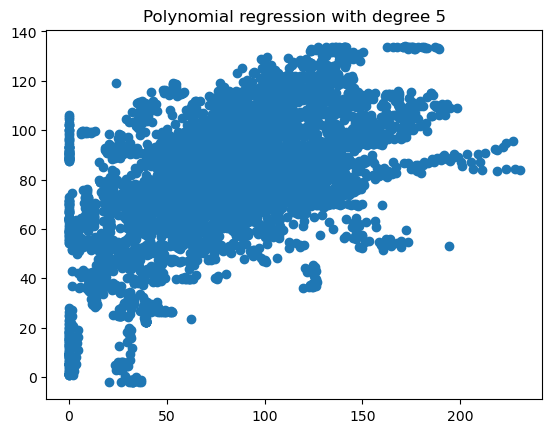

In [29]:
plt.figure()
plt.scatter(final_df["total_yield"],polyreg.predict(final_df.drop(["Country", "Year", "total_yield"], axis=1)))
plt.title("Polynomial regression with degree "+str(5))
plt.show()

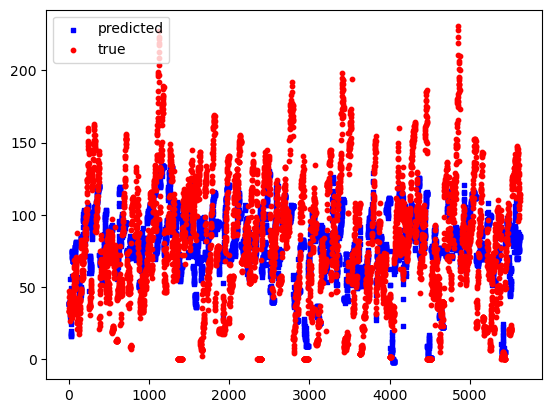

In [30]:
# Plots something for sure
x = range(len(pred))
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, polyreg.predict(final_df.drop(["Country", "Year", "total_yield"], axis=1)), s=10, c='b', marker="s", label='predicted')
ax1.scatter(x, final_df["total_yield"], s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left')
plt.show()

In [ ]:
mse_list

[7534.79297454455,
 8048412673210903.0,
 4.762997090892397e+28,
 2.8187100002241832e+41,
 1.668093831204757e+54,
 9.871668349997189e+66,
 5.841987674155866e+79,
 3.45724945115268e+92,
 2.0459772314091003e+105,
 1.2107957179800222e+118,
 7.165408530324059e+130,
 4.240441111907529e+143,
 2.509464847322857e+156,
 1.4850846064730022e+169,
 8.788631929775443e+181,
 5.2010539238238726e+194,
 3.077949120485567e+207,
 1.821509818404778e+220,
 1.0779573958719585e+233,
 6.379280175018167e+245,
 3.7752155796900944e+258,
 2.2341474715200507e+271,
 1.3221536145782632e+284,
 7.824417156102125e+296,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]